In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot
from pandas.tseries.offsets import DateOffset
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression

# Загрузка данных и создание датасета из сгрупированной информации по магазину


## № 1, 2

Загрузим данные по продажам из магазина № 25 и суммируем количество продаж по дате
Load data about sales at store number 25 and summarize it by date

In [2]:
list_for_df = []
rows = 0 # Посчитаем записи в исходном датасете
chunksize = 10**6
reader_df = pd.read_csv('train.csv', chunksize=chunksize, low_memory=False)
for i, chunk in enumerate(reader_df):
    list_for_df.append(chunk[chunk['store_nbr']==25][['date', 'unit_sales']].groupby(by='date').sum())
    rows += chunk.count()[0]
df = pd.concat(list_for_df)

In [3]:
print(f'Количество записей в исходном датасете : {rows}')

Количество записей в исходном датасете : 125497040


In [4]:
#check if there are duplicates in index
for i in range(len(df.index)-1):
    if df.index[i]==df.index[i+1]:
        print(i)

120


Один день записался в датасет по частям, суммируем его

In [5]:
df = df.groupby(by='date').sum()

<AxesSubplot:xlabel='date'>

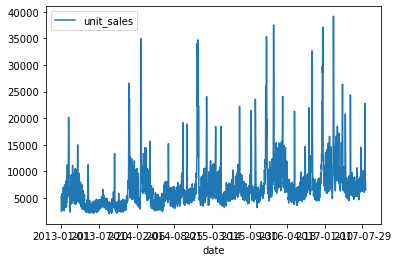

In [6]:
df.plot()

Посмотрим на пиковые данные ряда

In [7]:
df.sort_values(by='unit_sales', ascending=False).head(15)

unit_sales
date                  
2017-02-25   39140.267
2016-02-06   37484.340
2016-12-30   37096.791
2015-12-30   35315.079
2014-03-01   34928.132
2014-12-30   34706.024
2014-12-31   34619.440
2015-12-31   34061.519
2014-12-26   34044.995
2016-12-31   33025.686
2016-11-02   32651.703
2014-12-27   31033.916
2014-12-29   30488.513
2016-12-28   29750.092
2017-02-26   29087.078

Пики приходятся в основном на новогодние праздники, аномалий тут нет, заметна сезонность

In [8]:
# Приведем индекс в формат времени
df.index = pd.to_datetime(df.index, yearfirst=True)

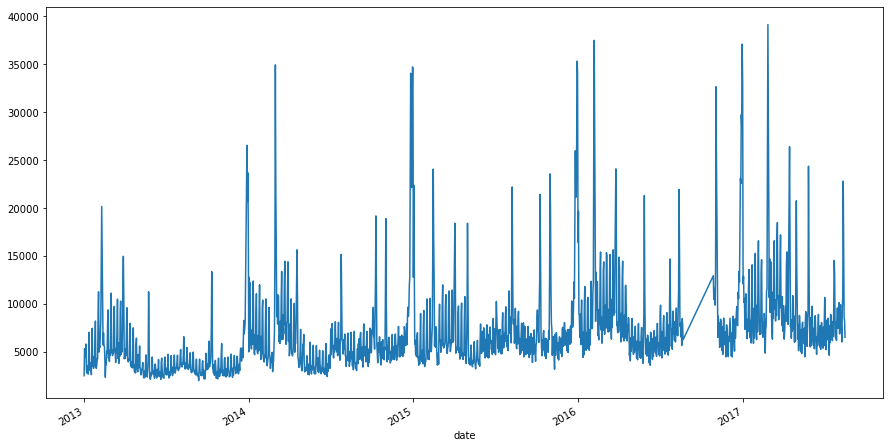

In [9]:
pyplot.figure(figsize=(15,8))
df['unit_sales'].plot(label='Sales')
pyplot.show()

Теперь на графике видно, что магазин не работал какое-то время во второй половине 2016 года

## № 3

Сделаем сезонную декомпозицию, чтобы оценить наличие треда и сезонности

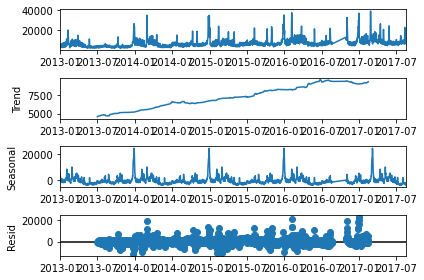

In [10]:
decomposition = seasonal_decompose(df, period=365)
decomposition.plot()
pyplot.show()

Как и предполагалось ранее, присутствует сезонная компонента. Также есть небольшой возрастающий тренд.

## № 4.1

In [11]:
print('Количество элементов в датасете :', df.count())

Количество элементов в датасете : unit_sales    1618
dtype: int64


## № 4.2

In [12]:
print('Количество всех значений шумовой части :',len(decomposition.resid))

Количество всех значений шумовой части : 1618


## № 4.3

In [13]:
print('Количество непустых значений шумовой части :',decomposition.resid.count())

Количество непустых значений шумовой части : 1254


## № 4.4

In [14]:
print('Количество непустых значений сезонной части :',decomposition.seasonal.count())

Количество непустых значений сезонной части : 1618


## № 4.5

In [15]:
print('Количество непустых значений трендовой части :',decomposition.trend.count())

Количество непустых значений трендовой части : 1254


## № 5

Проверим является ли ряд стационарным по тесту Дики-Фуллера

In [16]:
#dickey-fuller test
test = sm.tsa.adfuller(df['unit_sales'].dropna())
test

(-4.8589926653181825,
 4.188394192907736e-05,
 25,
 1592,
 {'1%': -3.4344642432857992,
  '5%': -2.8633571955690647,
  '10%': -2.5677374399794197},
 29431.756744370145)

In [17]:
p_value = test[1]
if p_value < 0.01:
    print(f'ряд стационарен. p-value = {p_value}')
else:
    print(f'ряд не стационарен. p-value = {p_value}')

ряд стационарен. p-value = 4.188394192907736e-05


Судя по тесту Дики - Фуллера, ряд стационарен. Хотя условно присутствует небольшой тренд, чего не должно быть в стационарном ряде

# Разбиение ряда на тренировочную и тестовую выборки

## № 1, 2

Разобьем данные на 3 последовательных набора тренировочных и тестовых выборок

In [18]:
from sklearn.model_selection import TimeSeriesSplit 
splitter = TimeSeriesSplit(n_splits=3, test_size=7)
splitted_data = splitter.split(df['unit_sales'])

In [19]:
print('Размеры получившихся выборок (тренировочная, тестовая)')
for i in splitted_data:
    print(len(i[0]),',', len(i[1]))

Размеры получившихся выборок (тренировочная, тестовая)
1597 , 7
1604 , 7
1611 , 7


# Сглаживание ряда

## № 1, 2, 3

Построим скользящее среднее и скользящее квадратическое отклонение на окне 5 дней

In [20]:
#mean window 5
df['window5mean'] = df['unit_sales'].rolling(window=5).mean()
#std window 5
df['window5deviation'] = df['unit_sales'].rolling(window=5).std()

## № 4

Определим доверительный интервал (линии Боллинджера) на окне 30 дней

In [21]:
def upper_bound(x):
    return np.mean(x) + 3 * np.std(x)

def lower_bound(x):
    return np.mean(x) - 3 * np.std(x)

df['upper'] = df['unit_sales'].rolling(window=30).apply(upper_bound)
df['lower'] = df['unit_sales'].rolling(window=30).apply(lower_bound)

## № 5

Посмотрим как это всё выглядит на графике

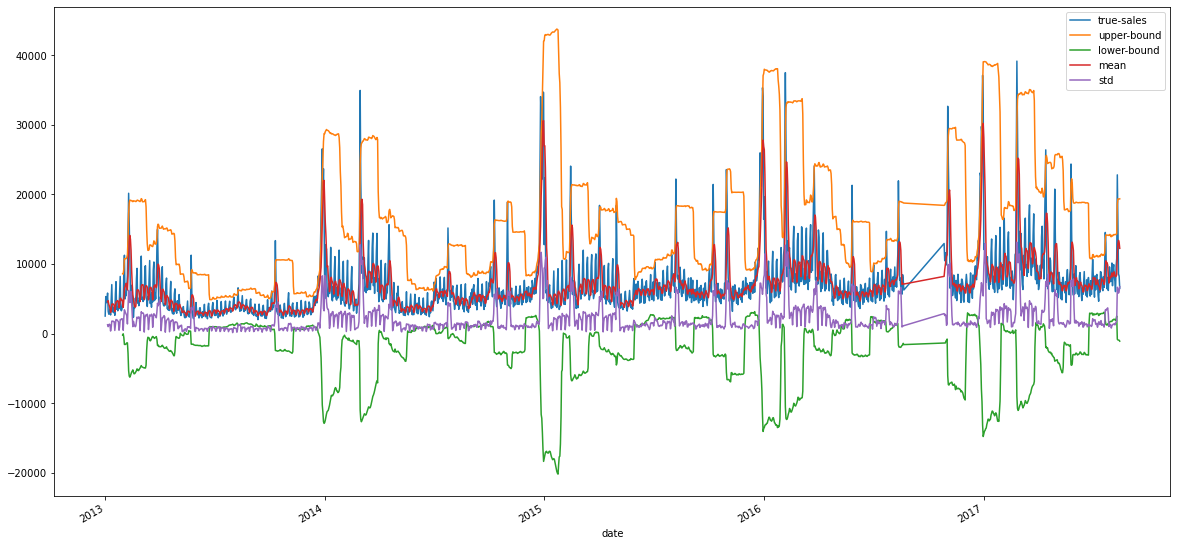

In [22]:
pyplot.figure(figsize=(20,10))
df['unit_sales'].plot(label='true-sales')
df['upper'].plot(label='upper-bound')
df['lower'].plot(label='lower-bound')
df['window5mean'].plot(label='mean')
df['window5deviation'].plot(label='std')
pyplot.legend()
pyplot.show()

## № 6

Скользящее среднее с окном 10 дней

In [23]:
df['window10mean'] = df['unit_sales'].rolling(window=10).mean()

## № 7

Скользящее экспоненциальное среднее с окном 7 дней

In [24]:
df['expmean7'] = df['unit_sales'].ewm(span=7).mean()

## № 8

Посмотрим их на графике

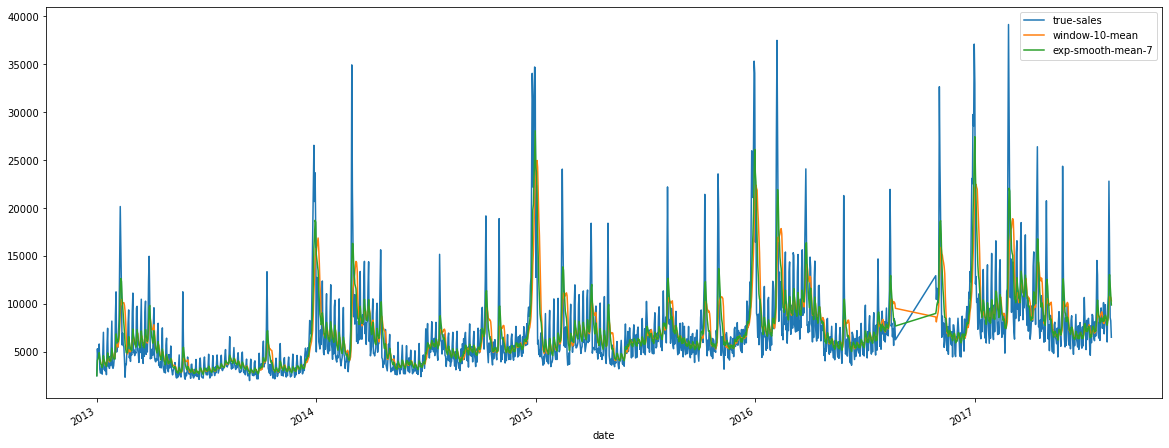

In [25]:
pyplot.figure(figsize=(20,8))
df['unit_sales'].plot(label='true-sales')
df['window10mean'].plot(label='window-10-mean')
df['expmean7'].plot(label='exp-smooth-mean-7')
pyplot.legend()
pyplot.show()

## № 9

Скользящая функция с окном 10, являющаяся средним арифметическим между максимальным и минимальным значением столбца на промежутке

In [26]:
def own_mean_func(x):
    return (np.min(x)+np.max(x))/2

df['own_mean10'] = df['unit_sales'].rolling(window=10).apply(own_mean_func)

## № 10

In [27]:
df['window50mean'] = df['unit_sales'].rolling(window=50).mean()
df['expmean10'] = df['unit_sales'].ewm(span=10).mean()
df['means_intersection'] = np.sign(df['window50mean']-df['expmean10']).diff()

In [28]:
df_intersec = df[df['means_intersection'] != 0].dropna()

## № 11

Возьмем лаги с 7 по 10 и отобразим на графике

In [29]:
df['lag7'] = df['unit_sales'].shift(7)
df['lag8'] = df['unit_sales'].shift(8)
df['lag9'] = df['unit_sales'].shift(9)
df['lag10'] = df['unit_sales'].shift(10)

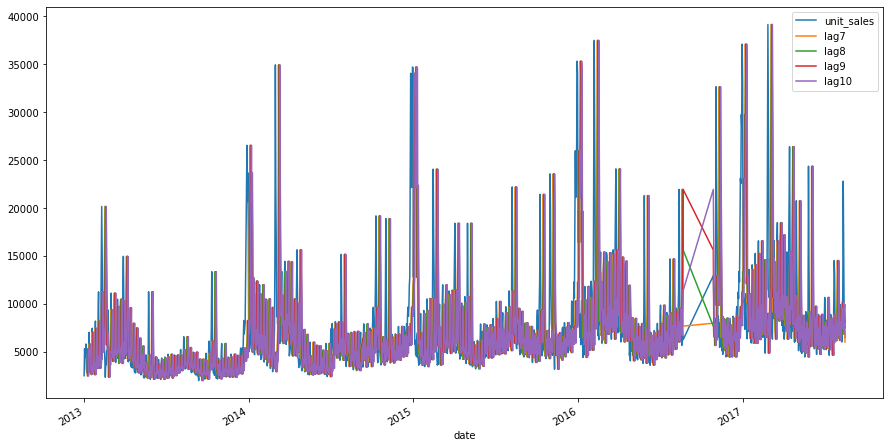

In [30]:
pyplot.figure(figsize=(15, 8))
df['unit_sales'].plot(label='unit_sales')
df['lag7'].plot(label='lag7')
df['lag8'].plot(label='lag8')
df['lag9'].plot(label='lag9')
df['lag10'].plot(label='lag10')
pyplot.legend()
pyplot.show()

# ARIMA/SARIMA

## № 1

Для прогнозирования методом ARIMA возьмем данные по продажам продукта №103501

In [31]:
chunksize = 10**6
reader_df = pd.read_csv('train.csv', chunksize=chunksize, low_memory=False)
item_list = []
for i, chunk in enumerate(reader_df):
    item_list.append(chunk[chunk['item_nbr']==103501].groupby(by='date')['unit_sales'].sum())

item_df = pd.concat(item_list)

In [32]:
item_df = pd.concat(item_list)
item_df = pd.DataFrame(item_df, columns=['unit_sales'])
item_df.index = pd.to_datetime(item_df.index)

# Суммируем по дате ещё раз, на случай если были дни разбитые на несколько строк
item_df = item_df.groupby(by='date')['unit_sales'].sum() 
item_df = pd.DataFrame(item_df)

<AxesSubplot:xlabel='date'>

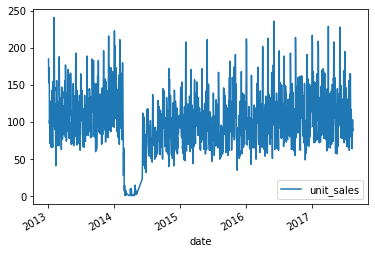

In [33]:
item_df.plot()

На графике видно, что в начале 2014 года было резкое падение продаж, после чего ряд немного изменил свой характер, при этом после 2014 года ряд выглядит стационарным. 

## № 2

Для уверенности проверим стационарность ряда тестом Дики Фулера

In [34]:
adf_test = sm.tsa.adfuller(item_df)
print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])
print('Critical Values:')
for key, value in adf_test[4].items():
    print('\t%s: %.3f' % (key, value))

if adf_test[0] < adf_test[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")

ADF Statistic: -4.154403
p-value: 0.000786
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
Reject Ho - Time Series is Stationary


Ряд стационарен

## № 3

Построим прогноз методом скользящего среднего с окном 6 и оценим качество метриками MSE, MAE, MAPE.

In [35]:
def moving_avg_forecast(series, window):
    forecast = []
    for i in range(len(item_df)-window):
        forecast.append(series[i:i+window].mean())
    return forecast

In [36]:
window = 6
forecast = moving_avg_forecast(item_df['unit_sales'], window)
forecast_df = pd.DataFrame(forecast, index=item_df.index[window:], columns=['forecast_sales'])
forecast_df

forecast_sales
date                      
2013-01-08      154.000000
2013-01-09      140.333333
2013-01-10      126.666667
2013-01-11      114.666667
2013-01-12      103.166667
...                    ...
2017-08-11       93.500000
2017-08-12       87.333333
2017-08-13       82.166667
2017-08-14       84.000000
2017-08-15       83.333333

[1619 rows x 1 columns]

mean_squared_error 1139.483889232036
mean_absolute_error 26.661828289067326
mean_absolute_percentage_error 0.326732641949257


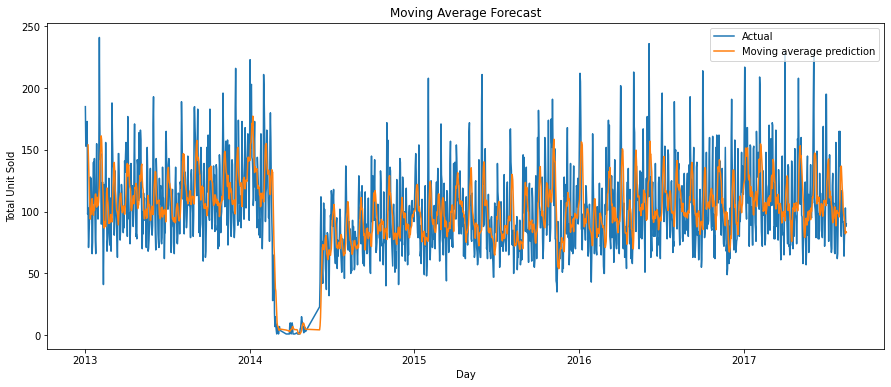

In [37]:
print("mean_squared_error",mean_squared_error(item_df['unit_sales'][window:], forecast_df['forecast_sales']))
print("mean_absolute_error",mean_absolute_error(item_df['unit_sales'][window:], forecast_df['forecast_sales']))
print("mean_absolute_percentage_error",mean_absolute_percentage_error(item_df['unit_sales'][window:], forecast_df['forecast_sales']))

pyplot.figure(figsize=(15,6))

pyplot.plot(item_df['unit_sales'], label="Actual")
pyplot.plot(forecast_df['forecast_sales'], label="Moving average prediction")
pyplot.ylabel("Total Unit Sold")
pyplot.xlabel("Day")
pyplot.title("Moving Average Forecast")
pyplot.legend(loc="upper right")

Средняя относительная ошибка, при прогнозе на день вперед с окном 6, составила 32%. Результат не супер, посмотрим что получится с линейной регрессией.

## № 4

Признаками для линейной регрессии возьмем лаги с 1 по 6

In [38]:
item_df['lag1'] = item_df['unit_sales'].shift(1)
item_df['lag2'] = item_df['unit_sales'].shift(2)
item_df['lag3'] = item_df['unit_sales'].shift(3)
item_df['lag4'] = item_df['unit_sales'].shift(4)
item_df['lag5'] = item_df['unit_sales'].shift(5)
item_df['lag6'] = item_df['unit_sales'].shift(6)

In [39]:
item_df.tail(10)

unit_sales   lag1   lag2   lag3   lag4   lag5   lag6
date                                                            
2017-08-06       115.0  117.0   80.0   94.0  120.0  165.0  137.0
2017-08-07        92.0  115.0  117.0   80.0   94.0  120.0  165.0
2017-08-08        92.0   92.0  115.0  117.0   80.0   94.0  120.0
2017-08-09        81.0   92.0   92.0  115.0  117.0   80.0   94.0
2017-08-10        64.0   81.0   92.0   92.0  115.0  117.0   80.0
2017-08-11        80.0   64.0   81.0   92.0   92.0  115.0  117.0
2017-08-12        84.0   80.0   64.0   81.0   92.0   92.0  115.0
2017-08-13       103.0   84.0   80.0   64.0   81.0   92.0   92.0
2017-08-14        88.0  103.0   84.0   80.0   64.0   81.0   92.0
2017-08-15        90.0   88.0  103.0   84.0   80.0   64.0   81.0

## № 5

Прогноз будем строить на 2 дня, поэтому из обучающей выборки уберем 1 лаг 

In [40]:
X = item_df.drop(['unit_sales', 'lag1'], axis=1).dropna()
y = item_df.dropna()['unit_sales']
X_train = X.iloc[:-2]
X_test = X.iloc[-2:]
y_train = y[:-2]
y_test = y[-2:]

## № 6

Оценим качество прогноза по 2 последним дням в данных

mean_squared_error 58.918518303691656
mean_absolute_error 7.644441228318229
mean_absolute_percentage_error 0.08581587137520072


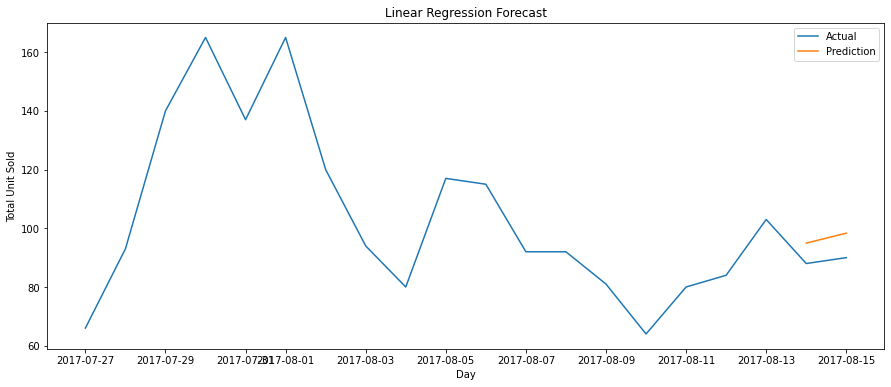

In [41]:
model = LinearRegression().fit(X_train, y_train)
prediction = model.predict(X_test)
prediction = pd.Series(prediction, index=y_test.index)

print("mean_squared_error",mean_squared_error(y_test, prediction))
print("mean_absolute_error",mean_absolute_error(y_test, prediction))
print("mean_absolute_percentage_error",mean_absolute_percentage_error(y_test, prediction))

pyplot.figure(figsize=(15,6))
pyplot.plot(y[-20:], label="Actual")
pyplot.plot(prediction, label="Prediction")
pyplot.ylabel("Total Unit Sold")
pyplot.xlabel("Day")
pyplot.title("Linear Regression Forecast")
pyplot.legend(loc="upper right")

Относительная ошибка составила 8,5%. Что лучше чем скользящим средним, хотя тут мы оценивали качество только по 2 последним дням, а там на всех данных 

## № 7

Попробуем теперь сделать прогноз на те же 2 дня с помощью ARIMA и сравним качество.
Для модели нам нужно знать порядок AR(p) и MA(q).
Построим графики корреляции и автокореляции для определения значений p и q.

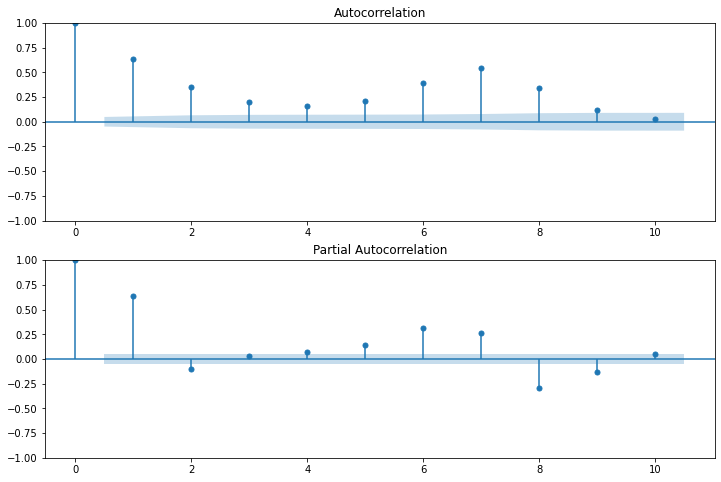

In [42]:
fig = pyplot.figure(figsize=(12,8))
ax1 = fig.add_subplot(2,1,1)
fig = sm.graphics.tsa.plot_acf(item_df['unit_sales'].values, lags=10, ax=ax1)
ax2 = fig.add_subplot(2,1,2)
fig = sm.graphics.tsa.plot_pacf(item_df['unit_sales'].values, lags=10, ax=ax2, method='ywm')

Последним значимым лагом на обоих графиках является 8. Таким образом p=8, q=8, d=0 (т.к. ряд был стационарным без деференцирования)

## № 8

Проверим качество модели при прогнозе на 2 дня  с полученными коэфициентами

In [43]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict

y_train = item_df['unit_sales'][:-2]
y_test = item_df['unit_sales'][-2:]
model = ARIMA(y_train.values.reshape(-1), order=(8,0,8))

/home/arsen/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


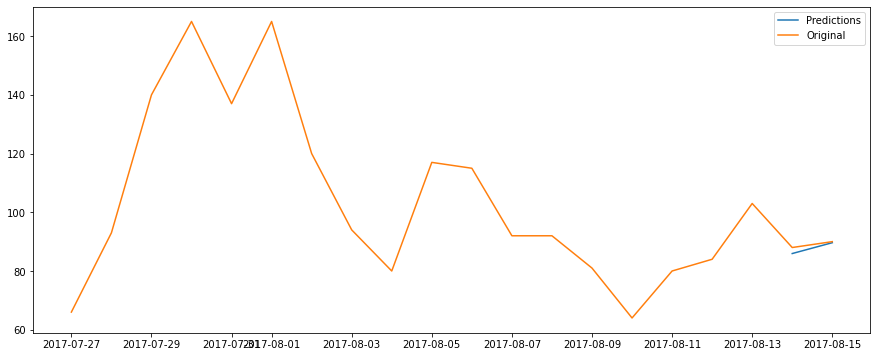

In [44]:
train_size = len(y_train)
test_size = len(y_test)
arima_predictions = model.fit().predict(start=train_size,end=train_size+test_size-1,  dynamic=False)

pyplot.figure(figsize=(15,6))
pyplot.plot(pd.Series(arima_predictions, index=y_test.index) ,label = "Predictions")
pyplot.plot(pd.concat([y_train, y_test], axis = 0)[-20:], label = "Original" )
pyplot.legend(loc="upper right")

In [45]:
print("mean_squared_error",mean_squared_error(y_test, arima_predictions))
print("mean_absolute_error",mean_absolute_error(y_test, arima_predictions))
print("mean_absolute_percentage_error",mean_absolute_percentage_error(y_test, arima_predictions))

mean_squared_error 2.165887307007388
mean_absolute_error 1.203714771593141
mean_absolute_percentage_error 0.01363350358952439


## № 9

## Вывод
На короткие промежутки времени (1-2 наблюдения) arima строит прогноз точнее линейной регрессии. При прогнозе на 2 дня средняя абсолютная ошибка в процентах у arima оказалась в 6 раз меньше, чем у прогноза линейной регрессии, 1.3% против 8.5% 

# Prophet

Для прогноза на более длинные промежутки времени воспользуемся алгоритмом от facebook - Prophet.

In [46]:
from prophet import Prophet
import plotly.offline as py
import plotly.graph_objs as go

## № 1

Загрузим данные, сразу суммируя продажи по дате

In [47]:
chunksize = 10**6
reader_df = pd.read_csv('train.csv', chunksize=chunksize, low_memory=False)
item_list = []
for i, chunk in enumerate(reader_df):
    item_list.append(chunk.groupby(by='date')['unit_sales'].sum())

df_sum = pd.DataFrame(pd.concat(item_list))
df_sum['ds'] = pd.to_datetime(df_sum.index)
df_sum = pd.DataFrame(df_sum.groupby(by='ds')['unit_sales'].sum())
df_sum.reset_index(inplace=True)

Посмотрим нет ли пропущенных дат в данных

In [48]:
all_dates = pd.date_range(start=df_sum['ds'][0], end=df_sum.iloc[-1]['ds'])
for i in all_dates:
    if i not in set(df_sum['ds']):
        print(i)

2013-12-25 00:00:00
2014-12-25 00:00:00
2015-12-25 00:00:00
2016-12-25 00:00:00


Отсутствует 25 декабря каждого года, это католическое рождество, соответственно магазины не работают. Для построения прогноза считаю нужным добавить эти даты и заполнить нулевым значением.

In [49]:
def fill_values(x):
    try:
        value = values[x]
        return value
    except:
        return 0

values = {}
for i in range(len(df_sum)):
    values[df_sum['ds'][i]] = df_sum['unit_sales'][i]
    
full_df = pd.DataFrame(all_dates, columns=['ds'])
full_df['y'] = full_df['ds'].apply(fill_values)

In [50]:
len(full_df)==len(all_dates)

True

In [51]:
df_sum = full_df

In [52]:
py.iplot([
    go.Scatter(x=df_sum['ds'], y=df_sum['y'], name='sales')])

Визуально по графику: конец каждого года сопровождается ростом продаж перед праздниками, затем отсутствие продаж на праздники. Можно сказать что присутствует годовая сезонность. Также со временем немного увеличивается дисперсия ряда. Для прогнозирования возможно следует сгладить ряд

## № 2

Сделаем прогноз на год без добавления дополнительной информации. Качество оценим по метрике RMSE.

In [53]:
model = Prophet()
model.fit(df_sum.iloc[:-365])
future_df = model.make_future_dataframe(periods=365)
forecast = model.predict(future_df)

18:02:05 - cmdstanpy - INFO - Chain [1] start processing
18:02:05 - cmdstanpy - INFO - Chain [1] done processing


In [54]:
py.iplot([
    go.Scatter(x=df_sum['ds'], y=df_sum['y'], name='true sales'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='forecast sales'),
    go.Scatter(x=forecast['ds'], y=forecast['trend'], name='trend')])

print("root_mean_squared_error",mean_squared_error(df_sum['y'][-365:], forecast['yhat'][-365:], squared=False))

root_mean_squared_error 142441.4392526342


По графику видно что модель неплохо определила рост продаж в конце года и растущий тренд. Однако падение продаж на праздники модель не уловила. Также тренд можно проработать детальнее. 

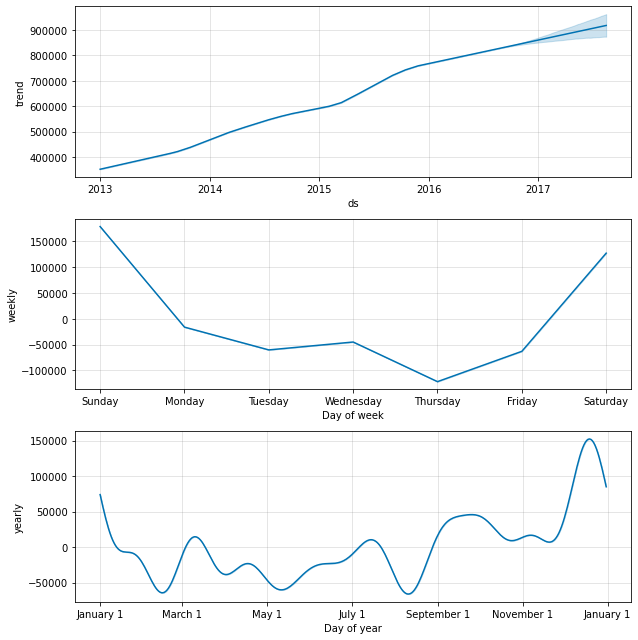

In [55]:
components = model.plot_components(forecast)

Видим в недельной сезонности ярко выражен рост продаж в выходные

## № 3

Попробуем улучшить качество поработав с чувствительностью тренда. Переберем несколько вариантов коэфициента чувствительности и оставим лучший по метрике RMSE.

In [56]:
scales = [0.01, 0.1, 0.5, 1]
best_error = 142000
best_scale = 0.05
for i in scales:
    model = Prophet(changepoint_prior_scale=i)
    model.fit(df_sum.iloc[:-365])
    future_df = model.make_future_dataframe(periods=365)
    forecast = model.predict(future_df)
    error = mean_squared_error(df_sum['y'][-365:], forecast['yhat'][-365:], squared=False)
    if error < best_error:
        best_error = error
        best_scale = i
        
print(f'Best scale is {best_scale}, with error {best_error}')

18:02:57 - cmdstanpy - INFO - Chain [1] start processing
18:02:57 - cmdstanpy - INFO - Chain [1] done processing
18:02:57 - cmdstanpy - INFO - Chain [1] start processing
18:02:57 - cmdstanpy - INFO - Chain [1] done processing
18:02:57 - cmdstanpy - INFO - Chain [1] start processing
18:02:58 - cmdstanpy - INFO - Chain [1] done processing
18:02:58 - cmdstanpy - INFO - Chain [1] start processing
18:02:58 - cmdstanpy - INFO - Chain [1] done processing


Best scale is 0.1, with error 139354.92417437182


18:03:04 - cmdstanpy - INFO - Chain [1] start processing
18:03:04 - cmdstanpy - INFO - Chain [1] done processing


error:  139354.92417437182


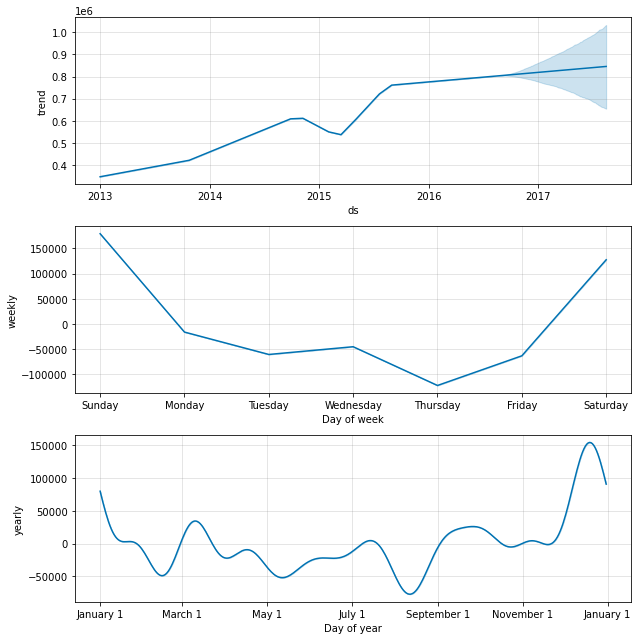

In [57]:
model = Prophet(changepoint_prior_scale=0.1)
model.fit(df_sum.iloc[:-365])
future_df = model.make_future_dataframe(periods=365)
forecast = model.predict(future_df)

py.iplot([
    go.Scatter(x=df_sum['ds'], y=df_sum['y'], name='true sales'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='forecast sales')])

error = mean_squared_error(df_sum['y'][-365:], forecast['yhat'][-365:], squared=False)
print('error: ', error)

components = model.plot_components(forecast)

Методом подбора определился оптимальный коэффициент гибкости тренда: 0.1 . С данным трендом ошибка уменьшилась до ~139000.

По графику видно, что изначальный тренд был слишком растущий и немного недообучен. На оптимальном тренде присутствует "яма" в начале 2015 года, в дальнейшем тренд линейно растущий. Причины падения тренда в данном периоде не понятны, по хорошему эту информацию нужно было бы выяснить и использовать для прогноза.

## № 5

Добавим в модель месячную сезонность и посмотрим как это повлияет на качество прогноза.

18:03:25 - cmdstanpy - INFO - Chain [1] start processing
18:03:25 - cmdstanpy - INFO - Chain [1] done processing


error =  132735.0473003064


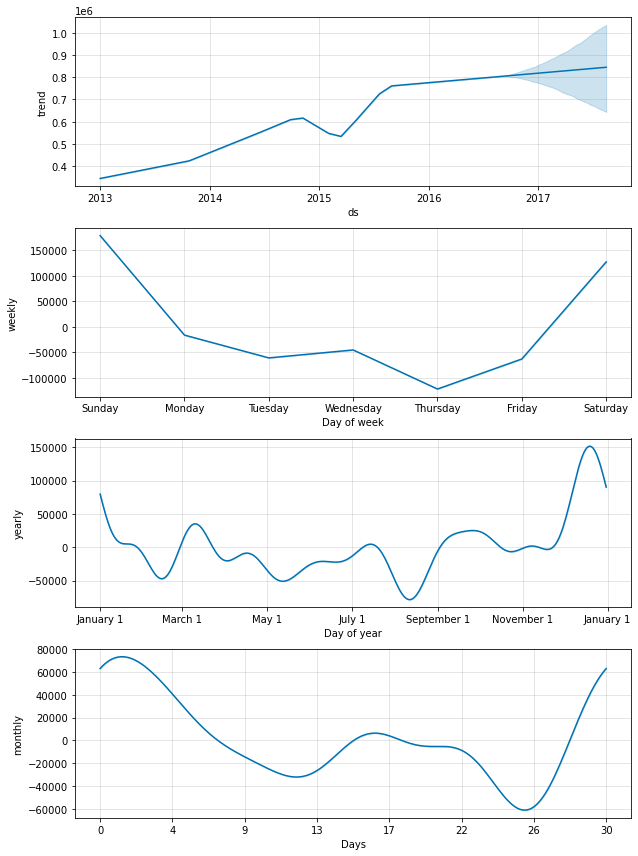

In [58]:
model = Prophet(changepoint_prior_scale=0.1)
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model.fit(df_sum[:-365])
future_df = model.make_future_dataframe(periods=365)
forecast = model.predict(future_df)

py.iplot([
    go.Scatter(x=df_sum['ds'], y=df_sum['y'], name='true sales'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='forecast sales')])

components = model.plot_components(forecast)
error = mean_squared_error(df_sum['y'][-365:], forecast['yhat'][-365:], squared=False)
print('error = ',error)

С добавлением месячной сезонности ошибка уменьшилась до ~132000.

## № 6

Посмотрим как повлияет добавление праздников...

In [59]:
df_holidays_events = pd.read_csv('holidays_events.csv')
holidays = df_holidays_events[df_holidays_events['transferred'] == False][['description', 'date']]
holidays.columns = ['holiday', 'ds']

18:03:33 - cmdstanpy - INFO - Chain [1] start processing
18:03:34 - cmdstanpy - INFO - Chain [1] done processing


error =  143132.70619151805


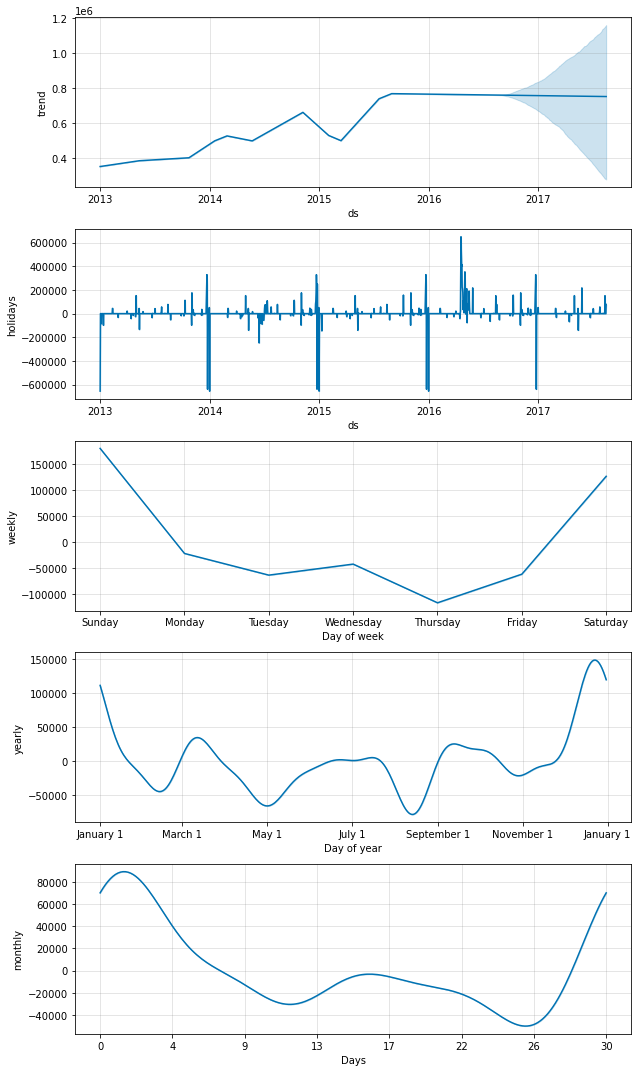

In [60]:
model = Prophet(changepoint_prior_scale=0.1, holidays=holidays, holidays_prior_scale=1)
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model.fit(df_sum.iloc[:-365])
future_df = model.make_future_dataframe(periods=365)
forecast = model.predict(future_df)

py.iplot([
    go.Scatter(x=df_sum['ds'], y=df_sum['y'], name='true sales'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='forecast sales')])

components = model.plot_components(forecast)
error = mean_squared_error(df_sum['y'][-365:], forecast['yhat'][-365:], squared=False)
print('error = ',error)

Добавление праздников повлияло негативно на тренд и в целом ухудшило качество.
Также модель практически не учла новогодние праздники в 2017.
Попробуем уменьшить чувствительность тренда и поставить акцент в праздниках только на новый год.

In [61]:
new_year = pd.DataFrame({'holiday':'new_year', 'ds': pd.to_datetime([
    '2013-01-01', '2013-12-25', '2014-01-01', '2014-12-25', '2015-01-01',
    '2015-12-25', '2016-01-01', '2016-12-25', '2017-01-01'])})

18:03:52 - cmdstanpy - INFO - Chain [1] start processing
18:03:52 - cmdstanpy - INFO - Chain [1] done processing


error =  106618.04582923092


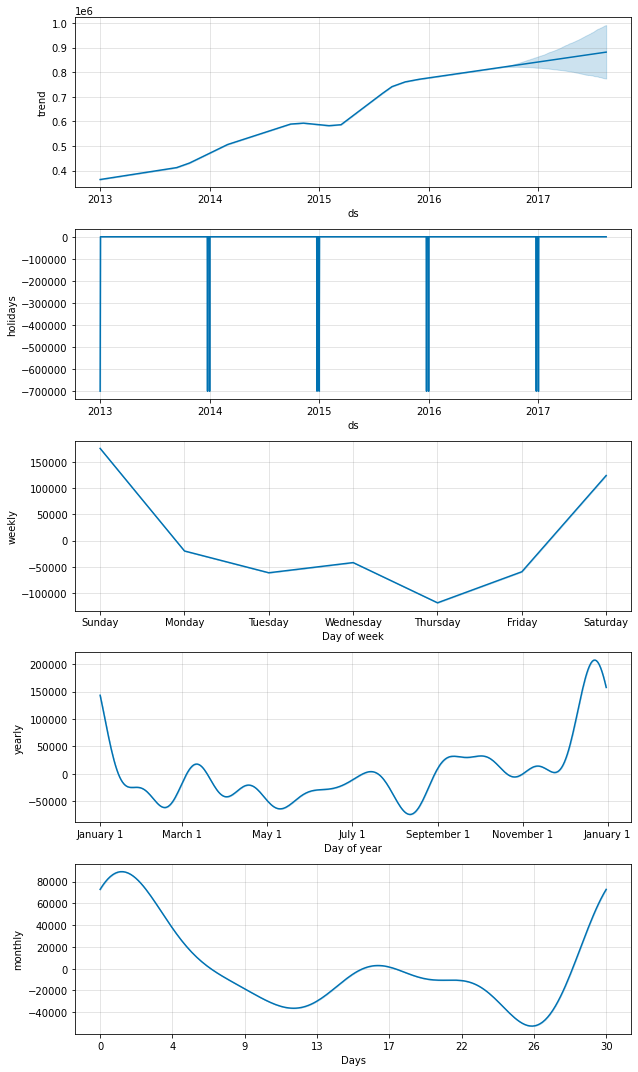

In [62]:
model = Prophet(changepoint_prior_scale=0.05, holidays=new_year)
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model.fit(df_sum.iloc[:-365])
future_df = model.make_future_dataframe(periods=365)
forecast = model.predict(future_df)

py.iplot([
    go.Scatter(x=df_sum['ds'], y=df_sum['y'], name='true sales'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='forecast sales')])

components = model.plot_components(forecast)
error = mean_squared_error(df_sum['y'][-365:], forecast['yhat'][-365:], squared=False)
print('error = ',error)

При уменьшении чувствительности тренда и акценте только на новогодних праздниках, удалось существенно улучшить качество до ошибки ~106000.

# XGBoost / CatBoost

## № 1, 2

Посмотрим как с прогнозом справятся ансамбли решаюших деревьев. Подготовим признаки на основании даты (день недели, месяца, года и т.д.). Для тестовой выборки отложим последний год данных.

In [63]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from catboost import CatBoostRegressor

In [64]:
df_sum['month'] = df_sum['ds'].dt.month
df_sum['day'] = df_sum['ds'].dt.day
df_sum['weekday'] = df_sum['ds'].dt.dayofweek
df_sum['dayofyear'] = df_sum['ds'].dt.dayofyear
df_sum['weekofyear'] = df_sum['ds'].dt.isocalendar().week.astype('int')
df_sum['quarter'] = df_sum['ds'].dt.quarter
df_sum['year'] = df_sum['ds'].dt.year

In [65]:
df_sum.head(10)

ds           y  month  day  weekday  dayofyear  weekofyear  quarter  \
0 2013-01-01    2511.619      1    1        1          1           1        1   
1 2013-01-02  496092.418      1    2        2          2           1        1   
2 2013-01-03  361429.231      1    3        3          3           1        1   
3 2013-01-04  354459.677      1    4        4          4           1        1   
4 2013-01-05  477350.121      1    5        5          5           1        1   
5 2013-01-06  519695.401      1    6        6          6           1        1   
6 2013-01-07  336122.801      1    7        0          7           2        1   
7 2013-01-08  318347.778      1    8        1          8           2        1   
8 2013-01-09  302530.809      1    9        2          9           2        1   
9 2013-01-10  258982.003      1   10        3         10           2        1   

   year  
0  2013  
1  2013  
2  2013  
3  2013  
4  2013  
5  2013  
6  2013  
7  2013  
8  2013  
9  2013

In [66]:
features = ['month', 'day', 'weekday', 'dayofyear', 'weekofyear', 'quarter', 'year']
X_train, y_train = df_sum[features].iloc[:-365], df_sum['y'].iloc[:-365]
X_test, y_test = df_sum[features].iloc[-365:], df_sum['y'].iloc[-365:]

## № 3, 4

Создадим и обучим модели xgboost и catboost

In [67]:
model = xgb.XGBRegressor(n_estimators=1000)
cbr = CatBoostRegressor(n_estimators=1000)
model.fit(X_train, y_train)
cbr.fit(X_train, y_train, verbose=False)

## № 5

Посмотрим важность признаков...

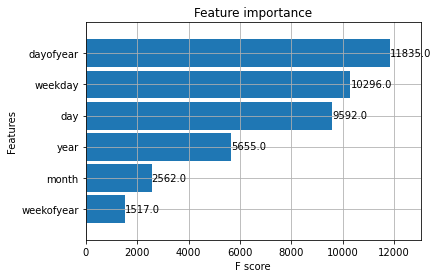

In [68]:
# xgboost feature importance
_ = plot_importance(model, height=0.9)

In [69]:
# catboost feature importance
cbr.get_feature_importance(prettified=True)

Feature Id  Importances
0        year    42.890788
1     weekday    24.506094
2   dayofyear    11.916902
3         day     6.940615
4       month     5.348200
5  weekofyear     4.851268
6     quarter     3.546133

Наиболее значимыми в обоих моделях являются день недели, день месяца и день года. Наименее значимы: квартал и месяц. Также значимым признаком для catboost еще является год.

## № 6

Проверим качество

In [70]:
print('XGBoost forecast:')
y_pred = model.predict(X_test)

print("mean_squared_error",mean_squared_error(y_test, y_pred))
print("mean_absolute_error",mean_absolute_error(y_test, y_pred))
print("mean_absolute_percentage_error",mean_absolute_percentage_error(y_test, y_pred))
print('root_mean_squared_error',mean_squared_error(y_test, y_pred, squared=False))

py.iplot([
    go.Scatter(x=df_sum['ds'], y=df_sum['y'], name='true sales'),
    go.Scatter(x=df_sum['ds'].iloc[-365:], y=y_pred, name='forecast sales')])

print('CatBoost forecast:')
y_pred = cbr.predict(X_test)

print("mean_squared_error",mean_squared_error(y_test, y_pred))
print("mean_absolute_error",mean_absolute_error(y_test, y_pred))
print("mean_absolute_percentage_error",mean_absolute_percentage_error(y_test, y_pred))
print('root_mean_squared_error',mean_squared_error(y_test, y_pred, squared=False))

py.iplot([
    go.Scatter(x=df_sum['ds'], y=df_sum['y'], name='true sales'),
    go.Scatter(x=df_sum['ds'].iloc[-365:], y=y_pred, name='forecast sales')])

XGBoost forecast:
mean_squared_error 20546572371.68846
mean_absolute_error 100395.71022328766
mean_absolute_percentage_error 9.7369458812108e+18
root_mean_squared_error 143340.75614314465


CatBoost forecast:
mean_squared_error 27062180303.070076
mean_absolute_error 123108.46716555255
mean_absolute_percentage_error 6.515747280953695e+18
root_mean_squared_error 164505.86707795583


## № 7

В целом качество обеих моделей примерно одинаковое, и от предыдущих методов также почти не отличается. Для большего эффектна можно попробовать добавить больше признаков

## № 8

Добавим колонку с праздниками в данные для catboost, а в данные для xgboost добавим колонку с обозначением европейских новогодних праздников (как самых значимых), чтобы не раздувать датафрейм мало значимыми дамми-переменными

In [71]:
import holidays
pl_holidays = holidays.PL()

def is_holiday(day):
    if day in pl_holidays:
        return pl_holidays.get(day)
    else:
        return "not"
    
def is_new_year(day):
    if day in pl_holidays:
        if pl_holidays.get(day)=="New Year's Day" or pl_holidays.get(day)=="Christmas (Day 1)":
            return 1
    return 0

df_sum['holiday'] = df_sum['ds'].apply(is_holiday)
df_sum['newyear'] = df_sum['ds'].apply(is_new_year)

In [72]:
features_cat = ['month', 'day', 'weekday', 'dayofyear', 'weekofyear', 'quarter', 'year', 'holiday']
features_xg = ['month', 'day', 'weekday', 'dayofyear', 'weekofyear', 'quarter', 'year', 'newyear']
X_train_cat, y_train = df_sum[features_cat].iloc[:-365], df_sum['y'].iloc[:-365]
X_train_xg = df_sum[features_xg].iloc[:-365]
X_test_cat, y_test = df_sum[features_cat].iloc[-365:], df_sum['y'].iloc[-365:]
X_test_xg = df_sum[features_xg].iloc[-365:]

In [73]:
model = xgb.XGBRegressor(n_estimators=1000)
cbr = CatBoostRegressor(n_estimators=1000)

model.fit(X_train_xg, y_train)
cbr.fit(X_train_cat, y_train, verbose=False, cat_features=['holiday'])

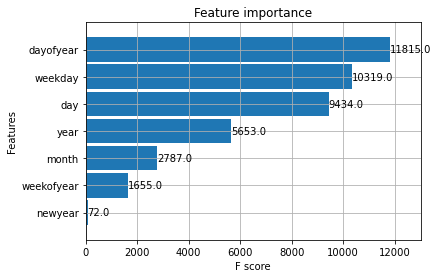

In [74]:
# xgboost feature importance
_ = plot_importance(model, height=0.9)

In [75]:
# catboost feature importance
cbr.get_feature_importance(prettified=True)

Feature Id  Importances
0        year    43.228157
1     weekday    23.909810
2   dayofyear    10.610554
3       month     6.859337
4         day     5.554280
5  weekofyear     3.992128
6     quarter     3.497974
7     holiday     2.347760

## № 9

Посчитаем метрики:

In [76]:
print('CatBoost forecast:')
y_pred = cbr.predict(X_test_cat)

print("mean_squared_error",mean_squared_error(y_test, y_pred))
print("mean_absolute_error",mean_absolute_error(y_test, y_pred))
print("mean_absolute_percentage_error",mean_absolute_percentage_error(y_test, y_pred))
print('root_mean_squared_error',mean_squared_error(y_test, y_pred, squared=False))

py.iplot([
    go.Scatter(x=df_sum['ds'], y=df_sum['y'], name='true sales'),
    go.Scatter(x=df_sum['ds'].iloc[-365:], y=y_pred, name='forecast sales')])

print('XGBoost forecast:')
y_pred = model.predict(X_test_xg)

print("mean_squared_error",mean_squared_error(y_test, y_pred))
print("mean_absolute_error",mean_absolute_error(y_test, y_pred))
print("mean_absolute_percentage_error",mean_absolute_percentage_error(y_test, y_pred))
print('root_mean_squared_error',mean_squared_error(y_test, y_pred, squared=False))

py.iplot([
    go.Scatter(x=df_sum['ds'], y=df_sum['y'], name='true sales'),
    go.Scatter(x=df_sum['ds'].iloc[-365:], y=y_pred, name='forecast sales')])

CatBoost forecast:
mean_squared_error 24012516981.24752
mean_absolute_error 120745.08697576518
mean_absolute_percentage_error 6.672068003660709e+18
root_mean_squared_error 154959.72696558136


XGBoost forecast:
mean_squared_error 18706657937.56631
mean_absolute_error 97971.05374383561
mean_absolute_percentage_error 9.65336323641413e+18
root_mean_squared_error 136772.28497603713


Качество у обоих моделей немного улучшилось после добавления праздников, однако на тестовой выборке они все равно не смогли определить новогодние спады. Fbprophet с праздниками справляется эффктивнее. В данном случае я бы в прогнозе заполнил дату нового года средним значением по прошлым годам, а рождество константой 0.

In [77]:
silwestr = df_sum[df_sum['holiday']=="New Year's Day"]['y'][:4].mean()
christmas = 0
df_pred = pd.DataFrame(df_sum['ds'].iloc[-365:])
df_pred['catboost'] = cbr.predict(X_test_cat)
df_pred['xgboost'] = model.predict(X_test_xg)
df_pred = df_pred.reset_index(drop=True)
df_pred.loc[138,('catboost', 'xgboost')] = (silwestr,silwestr)
df_pred.loc[131,('catboost', 'xgboost')] = (christmas,christmas)

In [78]:
#проверим верно ли заменили
df_pred[df_pred['ds']=='2016-12-25']

ds  catboost  xgboost
131 2016-12-25       0.0      0.0

In [79]:
print('XGBoost forecast:')
print("mean_squared_error",mean_squared_error(y_test, df_pred['xgboost']))
print("mean_absolute_error",mean_absolute_error(y_test, df_pred['xgboost']))
print("mean_absolute_percentage_error",mean_absolute_percentage_error(y_test, df_pred['xgboost']))
print('root_mean_squared_error',mean_squared_error(y_test, df_pred['xgboost'], squared=False))

py.iplot([
    go.Scatter(x=df_sum['ds'], y=df_sum['y'], name='true sales'),
    go.Scatter(x=df_sum['ds'].iloc[-365:], y=df_pred['xgboost'], name='forecast sales')])

print('CatBoost forecast:')
print("mean_squared_error",mean_squared_error(y_test, df_pred['catboost']))
print("mean_absolute_error",mean_absolute_error(y_test, df_pred['catboost']))
print("mean_absolute_percentage_error",mean_absolute_percentage_error(y_test, df_pred['catboost']))
print('root_mean_squared_error',mean_squared_error(y_test, df_pred['catboost'], squared=False))

py.iplot([
    go.Scatter(x=df_sum['ds'], y=df_sum['y'], name='true sales'),
    go.Scatter(x=df_sum['ds'].iloc[-365:], y=df_pred['catboost'], name='forecast sales')])

XGBoost forecast:
mean_squared_error 14631530848.327858
mean_absolute_error 93269.80909493151
mean_absolute_percentage_error 0.105556245575841
root_mean_squared_error 120960.8649453527


CatBoost forecast:
mean_squared_error 22051741712.601807
mean_absolute_error 117486.61020994952
mean_absolute_percentage_error 0.1321493116790559
root_mean_squared_error 148498.28858475713


Качество ещё немного улучшилось, однако все ещё хуже чем prophet.

## № 10

Добавим лаги и ещё раз сравним результат

In [80]:
df_sum['lag365'] = df_sum['y'].shift(365)
df_sum

ds           y  month  day  weekday  dayofyear  weekofyear  \
0    2013-01-01    2511.619      1    1        1          1           1   
1    2013-01-02  496092.418      1    2        2          2           1   
2    2013-01-03  361429.231      1    3        3          3           1   
3    2013-01-04  354459.677      1    4        4          4           1   
4    2013-01-05  477350.121      1    5        5          5           1   
...         ...         ...    ...  ...      ...        ...         ...   
1683 2017-08-11  826373.722      8   11        4        223          32   
1684 2017-08-12  792630.535      8   12        5        224          32   
1685 2017-08-13  865639.677      8   13        6        225          32   
1686 2017-08-14  760922.406      8   14        0        226          33   
1687 2017-08-15  762661.936      8   15        1        227          33   

      quarter  year                        holiday  newyear      lag365  
0           1  2013                 New Year's Day        1         NaN  
1           1  2013                            not        0         NaN  
2           1  2013                            not        0         NaN  
3           1  2013                            not        0         NaN  
4           1  2013                            not        0         NaN  
...       ...   ...                            ...      ...         ...  
1683        3  2017                            not        0  596729.280  
1684        3  2017                            not        0  745662.505  
1685        3  2017                            not        0  714905.919  
1686        3  2017                            not        0  761826.128  
1687        3  2017  Assumption of the Virgin Mary        0  720032.300  

[1688 rows x 12 columns]

Для обучения берем данные со второго года наблюдений до предпоследнего (т.к. лаг размером в год).

In [81]:
features_cat = ['month', 'day', 'weekday', 'dayofyear', 'weekofyear', 'quarter', 'year', 'holiday', 'lag365']
features_xg = ['month', 'day', 'weekday', 'dayofyear', 'weekofyear', 'quarter', 'year', 'newyear', 'lag365']
X_train_cat, y_train = df_sum[features_cat].iloc[365:-365], df_sum['y'].iloc[365:-365]
X_train_xg = df_sum[features_xg].iloc[365:-365]
X_test_cat, y_test = df_sum[features_cat].iloc[-365:], df_sum['y'].iloc[-365:]
X_test_xg = df_sum[features_xg].iloc[-365:]

In [82]:
model = xgb.XGBRegressor(n_estimators=1000)
cbr = CatBoostRegressor(n_estimators=1000)

model.fit(X_train_xg, y_train)
cbr.fit(X_train_cat, y_train, verbose=False, cat_features=['holiday'])

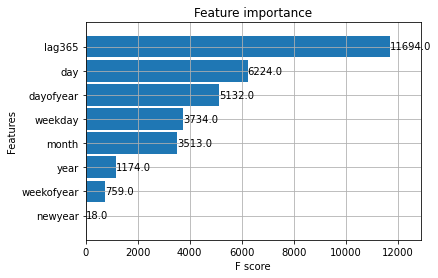

In [83]:
# xgboost feature importance
_ = plot_importance(model, height=0.9)

In [84]:
# catboost feature importance
cbr.get_feature_importance(prettified=True)

Feature Id  Importances
0     weekday    28.393553
1        year    25.021581
2   dayofyear    10.805047
3      lag365    10.648215
4       month     9.000195
5  weekofyear     6.589217
6         day     5.757982
7     quarter     3.358590
8     holiday     0.425620

Теперь год имеет меньше значения для модели CatBoost

In [85]:
df_pred = pd.DataFrame(df_sum['ds'].iloc[-365:])
df_pred['catboost'] = cbr.predict(X_test_cat)
df_pred['xgboost'] = model.predict(X_test_xg)
df_pred = df_pred.reset_index(drop=True)
df_pred.loc[138,('catboost', 'xgboost')] = (silwestr,silwestr)
df_pred.loc[131,('catboost', 'xgboost')] = (christmas,christmas)

print('XGBoost forecast:')
print("mean_squared_error",mean_squared_error(y_test, df_pred['xgboost']))
print("mean_absolute_error",mean_absolute_error(y_test, df_pred['xgboost']))
print("mean_absolute_percentage_error",mean_absolute_percentage_error(y_test, df_pred['xgboost']))
print('root_mean_squared_error',mean_squared_error(y_test, df_pred['xgboost'], squared=False))

py.iplot([
    go.Scatter(x=df_sum['ds'], y=df_sum['y'], name='true sales'),
    go.Scatter(x=df_sum['ds'].iloc[-365:], y=df_pred['xgboost'], name='forecast sales')])

print('CatBoost forecast:')
print("mean_squared_error",mean_squared_error(y_test, df_pred['catboost']))
print("mean_absolute_error",mean_absolute_error(y_test, df_pred['catboost']))
print("mean_absolute_percentage_error",mean_absolute_percentage_error(y_test, df_pred['catboost']))
print('root_mean_squared_error',mean_squared_error(y_test, df_pred['catboost'], squared=False))

py.iplot([
    go.Scatter(x=df_sum['ds'], y=df_sum['y'], name='true sales'),
    go.Scatter(x=df_sum['ds'].iloc[-365:], y=df_pred['catboost'], name='forecast sales')])

XGBoost forecast:
mean_squared_error 13896068120.472742
mean_absolute_error 90298.68560452053
mean_absolute_percentage_error 0.10335120409357607
root_mean_squared_error 117881.58516270784


CatBoost forecast:
mean_squared_error 18417864542.21045
mean_absolute_error 101828.02561104727
mean_absolute_percentage_error 0.11280717037093303
root_mean_squared_error 135712.4332631703


## № 11

## Вывод: 

C добавлением лага размером 365 дней качество обоих моделей еще немного улучшилось, однако всё еще хуже чем prophet. По графику видно что xgboost и catboost хуже улавливают растущий тренд. Таким образом для этих данных лучшим методом прогнозирования является prophet.

# Final forecast

To make total sum forecast for all stores for the next year we use prophet model. Save result as dataframe to csv file.

18:11:06 - cmdstanpy - INFO - Chain [1] start processing
18:11:06 - cmdstanpy - INFO - Chain [1] done processing


error =  207415.29971687877


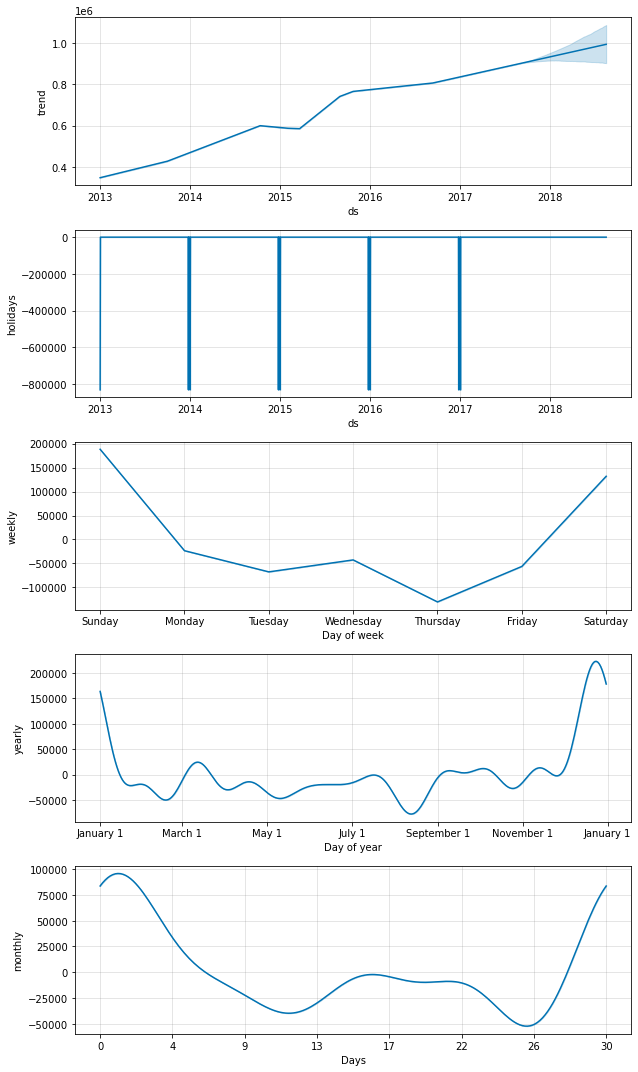

In [89]:
model = Prophet(changepoint_prior_scale=0.05, holidays=new_year)
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model.fit(df_sum.loc[:,['ds','y']])
future_df = model.make_future_dataframe(periods=365)
forecast = model.predict(future_df)

py.iplot([
    go.Scatter(x=df_sum['ds'], y=df_sum['y'], name='true sales'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='forecast sales')])

components = model.plot_components(forecast)
error = mean_squared_error(df_sum['y'][-365:], forecast['yhat'][-365:], squared=False)
print('error = ',error)

In [116]:
final_forecast = forecast.loc[:,['ds','yhat']][-365:]

# fill the christmas with zero
final_forecast['yhat'].loc[final_forecast['ds']=='2017-12-25'] = 0

In [120]:
final_forecast.to_csv('forecast.csv', index=False)